# Data Processing
We will clean and process the turnstile datasets in this file, and save the cleaned dictionaries to be loaded by analysis scripts later. This way, we don't need to parse through the raw data files every time we want to analyse it.

In [1]:
#Import libraries
import pickle
import csv
from dateutil import parser as psr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#Initialize the dictionaries to store our time series data.
#Each 
times_dict = {}
counts_dict = {}

In [3]:
#A helper function that takes the dictionary and split it into two time series
def splitvalues(dictionary, key):
    date_vector = []
    count_vector = []
    for value in dictionary[key]:
        date_vector.append(value[0])
        count_vector.append(value[1])
    return date_vector, count_vector

In [4]:
#WARNING: This block will take a minute to run
for fileno in range(4):#This iterates through all 4 files
    #Open a data file and read it into the dictionary
    with open('turnstile'+str(fileno+1)+'.txt','r') as filecsv:
        datadict = {};
        dataset = csv.reader(filecsv, dialect='excel')
        for line in dataset:
            strippedline= map(str.strip, line)
            key = tuple(strippedline[0:3])
            values = strippedline[3:]
            for i in range(len(values)):
                #the data rolls over after every 5th entry
                if (i % 5 == 0):
                    if (key not in datadict):
                        datadict[key] = []
                    if values[i+1][-5:] == '00:00':
                        time = psr.parse(values[i] + '-' + values[i+1])
                        datadict[key].append((time, values[i+4]))
            
    for key in datadict:
        times, counts = splitvalues(datadict, key)
        if key[0] not in times_dict:
            times_dict[key[0]] = []
            counts_dict[key[0]] = []
        exits_last_hour = list(np.diff(map(int, counts)))
        if times_dict[key[0]] != [] and times != []:
            if times[0] > times_dict[key[0]][-1]: #check if new week
                times_dict[key[0]] += times[1:]
                counts_dict[key[0]] += exits_last_hour
            else: #add turnstile exit data to control area total
                num_entries = min(len(exits_last_hour),\
                    len(counts_dict[key[0]][-len(exits_last_hour):]))
                if num_entries:
                    array1 = np.array(counts_dict[key[0]][-num_entries:])
                    array2 = np.array(exits_last_hour[-num_entries:])
                    counts_dict[key[0]][-num_entries:] = list(array1+array2)
        elif times != []:
            times_dict[key[0]] += times[1:]
            counts_dict[key[0]] += exits_last_hour

In [5]:
#Make a dictionary of the form {ControlArea:Station} to be used to combine control areas
with open('stationnames.csv') as filecsv2:
    station_dict = {};
    latlon_dict = {};
    CA_to_dict = csv.reader(filecsv2, delimiter=',')
    for line in CA_to_dict:
        station_dict[line[0]]=line[1]
        latlon_dict[line[0]]=[line[2],line[3]]

In [6]:
times_sta = {} #station time series (combining the control areas)
counts_sta = {}
for key in times_dict:
    if key in station_dict:
        newkey = station_dict[key]
        if newkey not in times_sta:
            times_sta[newkey] = times_dict[key]
            counts_sta[newkey] = counts_dict[key]
        else:
            for i in range(len(counts_sta[newkey])):
                if times_sta[newkey][i] == times_dict[key]:
                    counts_sta[newkey][i] += counts_dict[key][i]

In [7]:
#make a list of stations in the timeseries dataset
keylist = list(times_sta.keys())
sta = keylist[140]

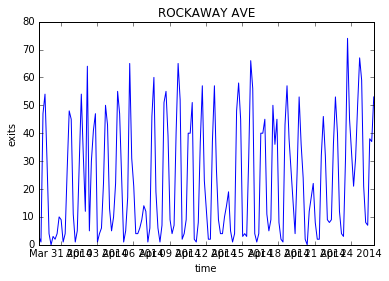

In [8]:
#plot time series for some random station to visualize the data
%matplotlib inline
plt.plot(times_sta[sta],counts_sta[sta])
plt.title(sta)
plt.xlabel('time')
plt.ylabel('exits')

In [9]:
# Saving the dictionaries and a list of keys:
with open('StationExitsTimeSeries.pickle', 'w') as file:
    pickle.dump([times_sta, counts_sta, keylist], file)